In [1]:
import numpy as np
import tensorflow as tf
import random, math
import matlab
import matlab.engine as me

In [2]:
## Hyper-Parameters
n = 2000 # number of samples
d = 30  # input dimension
k = 5   # hidden layer size
kappa = 2 
lr = 0.02
batch_size = 20

In [3]:
## Activation Function
def phi_s(h):
    return h**2 if h > 0 else 0
phi = np.vectorize(phi_s)

In [4]:
## Data and Params Generation

gauss_mat_u = np.random.normal(0.0, 0.1 , (d,k))
gauss_mat_v = np.random.normal(0.0, 0.1 , (k,k))

U, temp = np.linalg.qr(gauss_mat_u)
V, temp = np.linalg.qr(gauss_mat_v)

U, V = np.linalg.qr(gauss_mat_u)
diag = []
v_gt = []
v_choice = [1,-1]
for iter in range(k):
    diag.append(1+1.*iter*(kappa-1)/(k-1))
    v_gt.append(random.choice(v_choice))
    
Sigma = np.diag(diag)
W_gt = np.dot(np.dot(U, Sigma), np.transpose(V))
v_gt = np.asarray(v_gt)
train_x = []
train_y = []
for iter in range(n):
    train_x.append(np.random.normal(0.0,1.,d))
    train_y.append(np.dot(phi(np.dot(train_x[iter], W_gt)),v_gt))
train_x = np.asarray(train_x)
train_y = np.transpose(np.asarray(train_y))

In [5]:
## moments

def gamma(j,sigma):
    estm = 0
    for i in range(10000):
        z = np.random.normal(0.0, 1.0)
        estm += phi_s(z*sigma)*(z**j)
    return estm/10000

m = np.zeros((4,k))
for i in range(k):
    m[0,i] = gamma(1,np.linalg.norm(W_gt[:,i]))
    m[1,i] = gamma(2,np.linalg.norm(W_gt[:,i])) - gamma(0,np.linalg.norm(W_gt[:,i]))
    m[2,i] = gamma(3,np.linalg.norm(W_gt[:,i])) - 3*gamma(1,np.linalg.norm(W_gt[:,i]))
    m[3,i] = gamma(4,np.linalg.norm(W_gt[:,i])) + 3*gamma(0,np.linalg.norm(W_gt[:,i])) - 6*gamma(2,np.linalg.norm(W_gt[:,i]))

In [6]:
def outer3(a,b,c):
    A = np.outer(a,b)
    B = []
    for third in c:
        B.append(A*third)
    return np.asarray(B)

def outer4(a,b,c,d):
    A = outer3(a,b,c)
    B = []
    for fourth in d:
        B.append(A*fourth)
    return np.asarray(B)

def outer3I(x):
    return outer3(x,x,x)

def outer4I(x):
    return outer4(x,x,x,x)

def specOuterI(x):
    d = len(x)
    iden = np.identity(d)
    final = np.zeros([d,d,d])
    for i in range(d):
        final += outer3(x, iden[i], iden[i]) + outer3(iden[i], x, iden[i])+ outer3(iden[i], iden[i],x)
    return final

def specOuterMat(M):
    d = np.shape(M)[0]
    ## TODO
    return np.zeros([d,d,d,d])
    
    

In [7]:
# m[2,3]/np.linalg.norm(W_gt[:,3])**2

In [8]:
def multLnr(M, argList):
    if len(np.shape(M)) == 3:
        a,b,c = argList

        assert(np.shape(M)[0] == np.shape(a)[0])
        assert(np.shape(M)[1] == np.shape(b)[0])
        assert(np.shape(M)[2] == np.shape(c)[0])
        ## HardCoding Here :: TODO
        res = np.zeros([np.shape(a)[-1],np.shape(b)[-1] ])
        for itera in range(np.shape(a)[0]):
            for iterb in range(np.shape(b)[0]):
                for iterc in range(np.shape(c)[0]):
                    res += M[itera, iterb, iterc]*c[iterc]*np.outer(a[itera], b[iterb])
        return res
    else:
        assert(len(np.shape(M)) == 4)
        a,b,c,d = argList
        if len(np.shape(c)) == 2:
            pass
        else:
            res = np.zeros([np.shape(a)[-1],np.shape(b)[-1] ])
            for itera in range(np.shape(a)[0]):
                for iterb in range(np.shape(b)[0]):
                    for iterc in range(np.shape(c)[0]):
                        for iterd in range(np.shape(d)[0]):
                            res += M[itera, iterb, iterc]*c[iterc]*d[iterd]*np.outer(a[itera], b[iterb])
            return res
        
def multLnr1(M, V):
    d = np.shape(M)[0]
    k = np.shape(V)[1]
    
    res = np.zeros((k,k))
    
    for itera in range(d):
        for iterb in range(d):
            res += M[itera, iterb]*np.outer(V[itera], V[iterb])
            
    return res

def multLnr2(P3, V):
    d = np.shape(P3)[0]
    k = np.shape(V)[1]
    
    res = np.zeros((k,k,k))
    
    for itera in range(d):
        for iterb in range(d):
            for iterc in range(d):
                res += P3[itera, iterb, iterc]*outer3(V[itera], V[iterb], V[iterc])
    
    return res

In [13]:
# def prob(x):
#     return math.pow(math.e, -0.5*np.dot(np.transpose(x),x))/np.sqrt(math.pow(2*math.pi, len(x)))

def getM1(X, y):
    M1 = np.zeros(d)
    for iter in range(np.shape(X)[0]):
        M1 += y[iter]*X[iter]
    return M1/len(y)

def getM2(X, y):
    M2 = np.zeros([d,d])
    for iter in range(np.shape(X)[0]):
        M2 += y[iter]*(np.outer(X[iter], X[iter]) - np.identity(d))
    return M2/len(y)

def getM3(X, y):
    M3 = np.zeros([d,d,d])
    for iter in range(np.shape(X)[0]):
        M3 += y[iter]*(outer3I(X[iter]) - specOuterI(X[iter]) )
    return M3/len(y)

def getM4(X, y):
    M4 = np.zeros([d,d,d,d])
    for iter in range(np.shape(X)[0]):
        M4 += y[iter]*(outer4I(X[iter]) - specOuterMat(np.outer(X[iter], X[iter])) + specOuterMat(np.identity(d)) )
    return M4/len(y)

In [14]:
# M =  np.asarray(getM2(train_x, train_y))

# check = np.zeros((d,d))
# # check = np.zeros(d)
# for i in range(k):
#     check += v_gt[i]*m[1,i]*np.outer(W_gt[:,i], W_gt[:,i])
# #     check += v_gt[i]*m[0,i]*W_gt[:,i]
# print check
# print np.linalg.norm(M-check)/np.linalg.norm(check)
# print np.linalg.norm(M-check)/np.linalg.norm(M)

In [15]:
def getP2V(V, X, y, k):
    d = np.shape(X)[1]
    P2V = np.zeros((d,k))
    for i in range(len(X)):
        P2V += y[i]*(np.dot(np.transpose([X[i]]), np.dot([X[i]], V) ) - V)
    return P2V/np.shape(X)[0]
        
def getP2v(v, X, y):
    d = np.shape(X)[1]
    P2v = np.zeros((d,1))
    for i in range(len(X)):
        P2v += y[i]*(np.transpose([X[i]])*np.dot([X[i]], np.transpose([v]))  - np.transpose([v]))
    return P2v/np.shape(X)[0]

def topk(eigenV, k):
    sortList = []
    for i in range(2):
        for j in range(k):
            sortList.append([eigenV[i,j], (i,j)])
    sortList.sort(reverse=True)
    k1 = 0
    k2 = 0
    pi1 = {}
    pi2 = {}
    for i in range(k):
        if sortList[i][1][0] == 0:
            pi1[k1] = sortList[i][1][1]
            k1 += 1
        else:
            pi2[k2] = sortList[i][1][1]
            k2 += 1
    return pi1, pi2, k1, k2
    

In [16]:
def powMeth( k, X, y):
#     C = 3*np.linalg.norm(P2)
    C = 3*np.linalg.norm(getM2(X,y))
    T = 10000
    d =  np.shape(X)[1]
    V1 = np.random.normal(0.0, 0.1 , (d,k))
    V2 = np.random.normal(0.0, 0.1 , (d,k))
    
    for i in range(T):
        P2V1 = getP2V(V1, X, y, k)
        P2V2 = getP2V(V2, X, y, k)
        V1, temp = np.linalg.qr(C*V1 + P2V1)
        V2, temp = np.linalg.qr(C*V2 - P2V2)
    
    eigenV = np.zeros((2,k))
    for i in range(k):
        eigenV[0,i] = abs( np.dot(np.transpose(V1[:,i]) , getP2v(V1[:,i], X, y) ) )
    for i in range(k):
        eigenV[1,i] = abs(np.dot(np.transpose(V2[:,i]) , getP2v(V2[:,i], X, y) ))
    
    pi1, pi2, k1, k2 = topk(eigenV, k)
    
    V1_new = np.zeros((d,k1))
    V2_new = np.zeros((d,k2))
    
    for i in range(k1):
        V1_new[:,i] = V1[:,pi1[i]]
    for i in range(k2):
        V2_new[:,i] = V2[:,pi2[i]]
    V2_new, temp = np.linalg.qr(np.dot(np.identity(d)-np.dot(V1_new, np.transpose(V1_new)), V2_new))
    return np.concatenate((V1_new, V2_new), axis=1)
    

In [17]:
def recmagsgn(V, U, X, y):
    
    ### l1 and l2 :: TODO
    l1 = 1
    l2 = 2
    
    d = np.shape(X)[1]
    k = np.shape(U)[0]
    divInd = int(len(X)/2)
    
    # Partition
    X1 = X[:divInd]
    y1 = y[:divInd]

    X2 = X[divInd:]
    y2 = y[divInd:]
    
    alpha = np.random.normal(0.0, 0.1 , d)
    alpha = alpha/np.linalg.norm(alpha)
    
    ## TODO: Assuming l1=1 and l2=2 
    Q1 = getM1(X1, y1)
    Q2 = multLnr1(getM2(X2,y2), V).flatten()    
    
    Vu = []
    UU = []

    for ind in range(len(U)):
        Vu.append(np.dot(V, U[ind]))
        UU.append(np.dot( np.transpose([U[ind]]), [U[ind]] ).flatten())
        
    ## Estimating z
    z_old = np.zeros(k)
    z_new = np.zeros(k)
    
    T = 10000
    for iterT in range(T):
        for ind in range(k):
            
            mult_fact = np.zeros(d)
            for j in range(k):
                if j != ind:
                    mult_fact += z_old[j]*Vu[j]
            div_fact = np.dot(np.transpose(Vu[ind]), Vu[ind])
            z_new[ind] = (np.dot(np.transpose(Q1), Vu[ind]) + np.dot(np.transpose(Vu[ind]), Q1) -
                                 np.dot(np.transpose(Vu[ind]), mult_fact) - 
                                  np.dot(np.transpose(mult_fact), Vu[ind]) )/(2*div_fact)
        z_old = z_new
    
    ## Estimating r
    r = np.dot(np.linalg.inv(np.dot(UU, np.transpose(UU))), 
                                                   np.dot(UU,np.transpose([Q2]) ) )
    v = np.sign(r*np.transpose([m[l2-1]]))
    s = np.sign(v*np.transpose([z_new])*np.transpose([m[l2-1]]))

    p = 1 ## p + 1 is degree of homogenity

    w = []
    for ind in range(k):
        
        w.append(s[ind]*np.math.pow(abs(z_new[ind]*np.linalg.norm(W_gt[:,ind])**(p+1)/(m[l1-1,ind]*np.math.pow( np.dot( [alpha],
                    np.transpose([Vu[ind]]) ) ,l1-1))), 1.0/(p+1))*Vu[ind])
    w = np.asarray(w)

    return w,v

In [18]:
def tensorInit(X, y):
    divInd = int(len(X)/3)
    
    # Partition
    X1 = X[:divInd]
    y1 = y[:divInd]

    X2 = X[divInd:2*divInd]
    y2 = y[divInd:2*divInd]
    
    X3 = X[2*divInd:]
    y3 = y[2*divInd:]
    
    ## P2 
    ## Estimating P2 as M2 :: TODO
    
#     alpha = np.random.normal(0.0, 0.1 , d)
#     P2 = getM2(X1,y1)
#     print(np.linalg.norm(P2))

    ## Power Method
    V = powMeth(k, X1, y1)
    
    ## R3
    R3 = multLnr2(getM3(X2, y2), V)
    
    #### KCL
    R = matlab.double(R3.flatten().tolist())
    eng = me.start_matlab()
    U = eng.notf_frompy(R, 100, k)
    eng.quit()
    U = np.asarray(U)
#     U = R3[0]

    ## RecMagSign
    return recmagsgn(V, U, X3, y3) 

In [19]:
tensorWeights = tensorInit(train_x, train_y)

In [47]:
tensorWeights

(array([[-0.05224457,  0.23042807, -0.1175749 ,  0.16702047,  0.17657808,
         -0.05569402,  0.22921827, -0.24372486, -0.26783597, -0.1631667 ,
          0.24095493, -0.14074936, -0.00665661,  0.18733078, -0.29721189,
         -0.06992958,  0.05275971, -0.24515093,  0.19360093, -0.0253632 ,
         -0.01153394, -0.02308832, -0.03359161,  0.1317134 ,  0.0282088 ,
          0.43556966, -0.49087687,  0.10835563,  0.19957721,  0.03709088],
        [-0.00854335, -0.00675476, -0.01328092,  0.00847862, -0.02461828,
          0.04737665,  0.03104783, -0.0013089 , -0.03697157,  0.0845654 ,
         -0.03286064, -0.06832903, -0.01931108, -0.00615856, -0.0533922 ,
         -0.06985842, -0.02460134, -0.0110278 ,  0.02377181,  0.0161817 ,
          0.01770176, -0.04575858, -0.04052705,  0.0293219 , -0.00901915,
         -0.01101586,  0.03833602, -0.0310053 , -0.01514332, -0.07892804],
        [ 0.03880471,  0.00389723,  0.05263819, -0.07451318,  0.0189947 ,
         -0.1221766 , -0.04026404,  

In [21]:
def init_weights(shape):
    """ Weight initialization """
    weights = tf.random_normal(shape, stddev=0.1)
    return tf.Variable(weights)

def forwardprop(X, w_1, w_2):
    """
    Forward-propagation.
    """
    h    = tf.square(tf.nn.relu((tf.matmul(X, w_1))))
    yhat = tf.matmul(h, w_2)  # The \varphi function
    return yhat

In [ ]:
X = tf.placeholder("float", shape=[None, d])
y = tf.placeholder("float", shape=[None, 1])

# Weight initializations

# w_1 = init_weights((d, k))
# w_2 = []
# v_choice = [1,-1]
# for iter in range(k):
#     w_2.append(random.choice(v_choice))
# w_2 = tf.cast(tf.Variable(np.transpose(np.asarray([w_2])), trainable=False), tf.float32)

# w_2 = init_weights((k, 1))

w_1 = tf.Variable(np.transpose(tensorWeights[0]))
# w_2 = tf.Variable(tensorWeights[1], trainable=False)
w_2 = tf.Variable( np.transpose([v_gt]), trainable=False)

w_1 = tf.cast(w_1, tf.float32)
w_2 = tf.cast(w_2, tf.float32)

# Forward propagation
yhat  = forwardprop(X, w_1, w_2)

# Backward propagation
cost = tf.losses.mean_squared_error(y, yhat)
updates = tf.train.GradientDescentOptimizer(lr).minimize(cost)

# Run SGD
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
init = tf.global_variables_initializer()
sess.run(init)
epsilon = 1e-4
x_e = []
y_tl = []
T= 1000
for epoch in range(T):
    # Train with each example
    i = 0
#     print sess.run(w_1, feed_dict={X:train_x})
#     print sess.run(w_2, feed_dict={X:train_x})
    for iter in range(int(n/batch_size)):
        sess.run(updates, feed_dict={X: train_x[i: i + batch_size], y: train_y[i: i + batch_size].reshape(batch_size,1)})
        i = (i + batch_size)%n
#     train_accuracy = np.mean((train_y - sess.run(yhat, feed_dict={X:train_x, y:train_y.reshape(n,1)})) <= epsilon)
    loss = sess.run(cost, feed_dict={X:train_x, y:train_y.reshape(n,1)})
    print "Epoch = ", epoch+1,"training loss: ", loss #," train Acc: ",100.*train_accuracy 
    x_e.append(epoch+1)
    y_tl.append(loss)

Epoch =  1 training loss:  1.15917
Epoch =  2 training loss:  1.042
Epoch =  3 training loss:  0.983065
Epoch =  4 training loss:  0.916009
Epoch =  5 training loss:  0.738114
Epoch =  6 training loss:  0.316541
Epoch =  7 training loss:  0.197126
Epoch =  8 training loss:  0.257117
Epoch =  9 training loss:  0.281459
Epoch =  10 training loss:  0.286934
Epoch =  11 training loss:  0.287955
Epoch =  12 training loss:  0.28797
Epoch =  13 training loss:  0.28777
Epoch =  14 training loss:  0.287535
Epoch =  15 training loss:  0.287338
Epoch =  16 training loss:  0.287186
Epoch =  17 training loss:  0.287071
Epoch =  18 training loss:  0.286991
Epoch =  19 training loss:  0.286938
Epoch =  20 training loss:  0.286902
Epoch =  21 training loss:  0.286874
Epoch =  22 training loss:  0.286853
Epoch =  23 training loss:  0.286839
Epoch =  24 training loss:  0.286827
Epoch =  25 training loss:  0.286819
Epoch =  26 training loss:  0.286814
Epoch =  27 training loss:  0.28681
Epoch =  28 train

Epoch =  229 training loss:  0.2868
Epoch =  230 training loss:  0.2868
Epoch =  231 training loss:  0.2868
Epoch =  232 training loss:  0.2868
Epoch =  233 training loss:  0.2868
Epoch =  234 training loss:  0.2868
Epoch =  235 training loss:  0.2868
Epoch =  236 training loss:  0.2868
Epoch =  237 training loss:  0.2868
Epoch =  238 training loss:  0.2868
Epoch =  239 training loss:  0.286799
Epoch =  240 training loss:  0.2868
Epoch =  241 training loss:  0.2868
Epoch =  242 training loss:  0.2868
Epoch =  243 training loss:  0.2868
Epoch =  244 training loss:  0.2868
Epoch =  245 training loss:  0.2868
Epoch =  246 training loss:  0.2868
Epoch =  247 training loss:  0.2868
Epoch =  248 training loss:  0.2868
Epoch =  249 training loss:  0.2868
Epoch =  250 training loss:  0.2868
Epoch =  251 training loss:  0.2868
Epoch =  252 training loss:  0.2868
Epoch =  253 training loss:  0.2868
Epoch =  254 training loss:  0.2868
Epoch =  255 training loss:  0.2868
Epoch =  256 training loss

Epoch =  457 training loss:  0.2868
Epoch =  458 training loss:  0.2868
Epoch =  459 training loss:  0.2868
Epoch =  460 training loss:  0.2868
Epoch =  461 training loss:  0.2868
Epoch =  462 training loss:  0.286799
Epoch =  463 training loss:  0.2868
Epoch =  464 training loss:  0.2868
Epoch =  465 training loss:  0.2868
Epoch =  466 training loss:  0.2868
Epoch =  467 training loss:  0.2868
Epoch =  468 training loss:  0.286801
Epoch =  469 training loss:  0.2868
Epoch =  470 training loss:  0.2868
Epoch =  471 training loss:  0.2868
Epoch =  472 training loss:  0.2868
Epoch =  473 training loss:  0.2868
Epoch =  474 training loss:  0.2868
Epoch =  475 training loss:  0.286801
Epoch =  476 training loss:  0.2868
Epoch =  477 training loss:  0.2868
Epoch =  478 training loss:  0.286801
Epoch =  479 training loss:  0.2868
Epoch =  480 training loss:  0.286799
Epoch =  481 training loss:  0.2868
Epoch =  482 training loss:  0.2868
Epoch =  483 training loss:  0.2868
Epoch =  484 train

Epoch =  685 training loss:  0.2868
Epoch =  686 training loss:  0.2868
Epoch =  687 training loss:  0.2868
Epoch =  688 training loss:  0.286799
Epoch =  689 training loss:  0.2868
Epoch =  690 training loss:  0.2868
Epoch =  691 training loss:  0.286799
Epoch =  692 training loss:  0.2868
Epoch =  693 training loss:  0.2868
Epoch =  694 training loss:  0.2868
Epoch =  695 training loss:  0.2868
Epoch =  696 training loss:  0.286801
Epoch =  697 training loss:  0.2868
Epoch =  698 training loss:  0.2868
Epoch =  699 training loss:  0.2868
Epoch =  700 training loss:  0.2868
Epoch =  701 training loss:  0.2868
Epoch =  702 training loss:  0.2868
Epoch =  703 training loss:  0.286801
Epoch =  704 training loss:  0.2868
Epoch =  705 training loss:  0.2868
Epoch =  706 training loss:  0.2868
Epoch =  707 training loss:  0.2868
Epoch =  708 training loss:  0.2868
Epoch =  709 training loss:  0.2868
Epoch =  710 training loss:  0.2868
Epoch =  711 training loss:  0.2868
Epoch =  712 trainin

In [73]:
import itertools
permList = list(itertools.permutations(range(k)))

# w_p = tensorWeights[0]
# w_p = np.random.normal(0, 0.1 , (k,d))
w_p = np.transpose(sess.run(w_1))
# v_p = tensorWeights[1]
v_p = sess.run(w_2)
temp = []
for i in v_p:
    temp.append(i[0])
v_p = np.asarray(temp)
for perm in permList:
    w_pi = w_p[list(perm)]
    v_pi = v_p[list(perm)]
    
    w_gt = np.transpose(W_gt)
    
    if sum(v_gt == v_pi) == k:
        max_diff = 0
        for i in range(k):
            diff = np.linalg.norm(w_pi[i]-w_gt[i])/np.linalg.norm(w_gt)
            if diff > max_diff:
                max_diff = diff
        if max_diff < 0.5:
            print "Success"
            break
    else:
        continue

In [35]:
import matplotlib.pyplot as plt

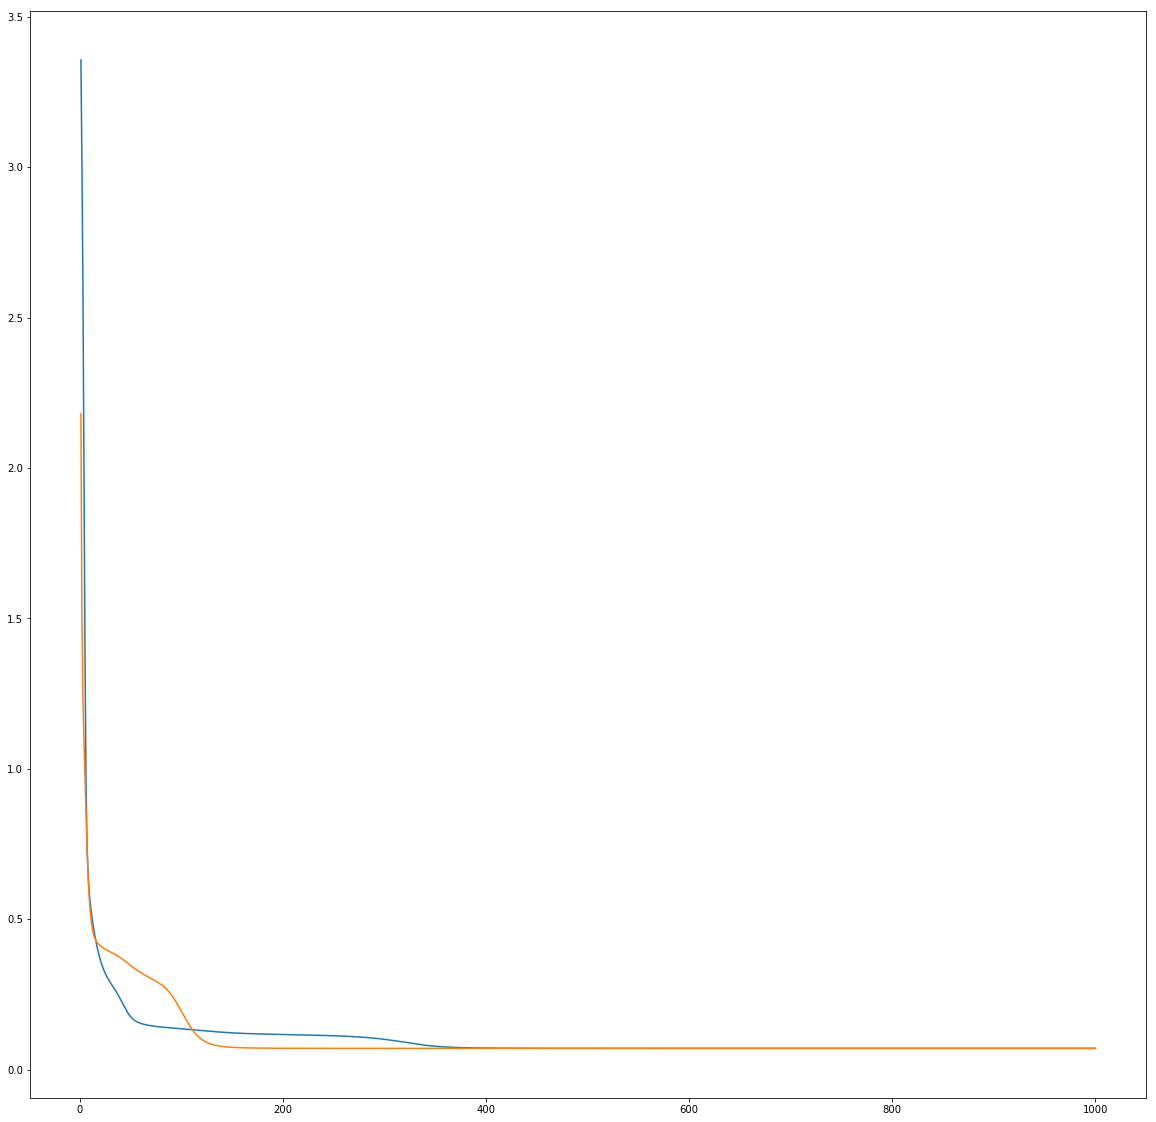

In [41]:
# y_s = y_tl
plt.plot(x_e, y_tl)
plt.plot(x_e, y_s)
plt.rcParams["figure.figsize"] = [20,20]
plt.show()